In [1]:
import numpy as np
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask
from arte.atmo.phase_screen_generator import PhaseScreenGenerator

from arte.optical_propagation.lyot_coronograph import LyotCoronograph, KnifeEdgeCoronograph
from arte.optical_propagation.four_quadrant_coronograph import FourQuadrantCoronograph
from arte.optical_propagation.vortex_coronograph import VortexCoronograph
from arte.optical_propagation.perfect_coronograph import PerfectCoronograph

In [2]:
Npix = 160
Nmeters = 1
L0 = 25

phs = PhaseScreenGenerator(Npix,Nmeters,outerScaleInMeters=L0)
phs.rescale_to(15e-2)
phs.generate_normalized_phase_screens(1)
screens = phs.get_in_meters()
screen = screens[0]

Text(0.5, 1.0, 'PTT Filtered phase')

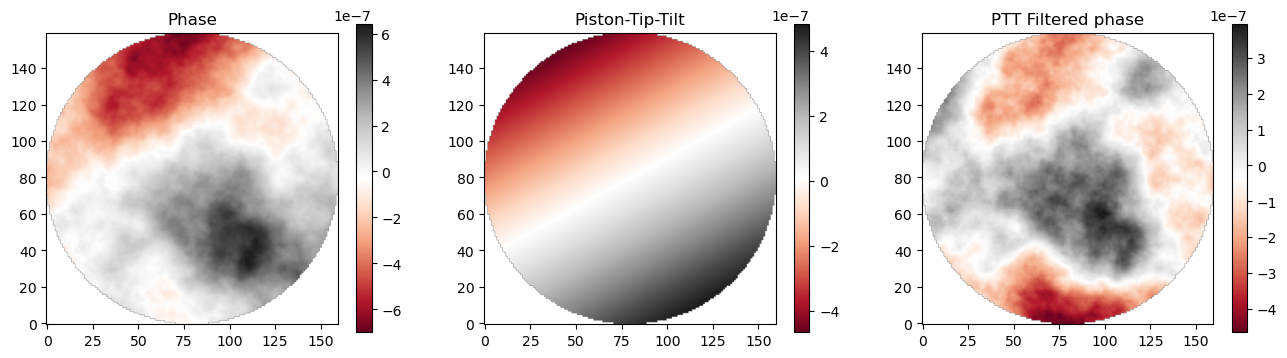

In [3]:
cmask = CircularMask((screen.shape[0],screen.shape[1]),maskRadius=Npix//2)
phase = screen[~cmask.mask()]

# Remove piston-tip-tilt
X,Y = np.mgrid[0:screen.shape[0],0:screen.shape[1]]
tilt = X[~cmask.mask()]
tip = Y[~cmask.mask()]
piston = np.ones(np.sum(1-cmask.mask()))
ptt = np.vstack([piston,tip,tilt]).T
phase2ptt = np.linalg.pinv(ptt)
ptt_coeffs = phase2ptt @ phase
ptt_fit = ptt @ ptt_coeffs
filt_phase = phase - ptt_fit

ptt_image = np.zeros_like(screen)
ptt_image[~cmask.mask()] = ptt_fit
ptt_image = np.reshape(ptt_image, cmask.mask().shape)

filt_image = np.zeros_like(screen)
filt_image[~cmask.mask()] = filt_phase
filt_image = np.reshape(filt_image, cmask.mask().shape)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(np.ma.masked_array(screen,mask=cmask.mask()),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title('Phase')
plt.subplot(1,3,2)
plt.imshow(np.ma.masked_array(ptt_image,mask=cmask.mask()),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title('Piston-Tip-Tilt')
plt.subplot(1,3,3)
plt.imshow(np.ma.masked_array(filt_image,mask=cmask.mask()),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title('PTT Filtered phase')

In [4]:
lambdaInM = 750e-9
oversampling = 12

phase_in_rad = filt_image/10 * 2*np.pi/lambdaInM
# divide by 10 to limit aberrations

input_field = cmask.asTransmissionValue() * np.exp(1j*phase_in_rad,dtype=np.complex64)
pad_width = int(max(input_field.shape)*(oversampling-1))//2
padded_field = np.pad(input_field,pad_width=pad_width,mode='constant',constant_values=0.0)
psf = abs(np.fft.fftshift(np.fft.fft2(padded_field)))**2

maxLogPsf = np.max(np.log(psf))

In [5]:
perfCoro = PerfectCoronograph()
lyot = LyotCoronograph(referenceLambdaInM=lambdaInM,
                       inFocalStopInLambdaOverD=2.0, 
                       outPupilStopInFractionOfPupil=0.95, 
                       outFocalStopInLambdaOverD=50)
kedge = KnifeEdgeCoronograph(referenceLambdaInM=lambdaInM,
                             iwaFocalStopInLambdaOverD=3.0, 
                             outPupilStopInFractionOfPupil=0.95,
                             inPupilStopInFractionOfPupil=0.05)
fquad = FourQuadrantCoronograph(referenceLambdaInM=lambdaInM,
                                outPupilStopInFractionOfPupil=0.95)
vortex = VortexCoronograph(referenceLambdaInM=lambdaInM,
                           charge=6, addInVortex=True, inVortexRadInLambdaOverD=10,
                           outPupilStopInFractionOfPupil=0.95)

lyot_psf = lyot.get_coronographic_psf(input_field, oversampling, lambdaInM)
perfect_coro_psf = perfCoro.get_coronographic_psf(input_field, oversampling, lambdaInM)
kedge_psf = kedge.get_coronographic_psf(input_field,oversampling, lambdaInM)
fquad_psf = fquad.get_coronographic_psf(input_field,oversampling, lambdaInM=900e-9)
vortex_psf = vortex.get_coronographic_psf(input_field,oversampling, lambdaInM)

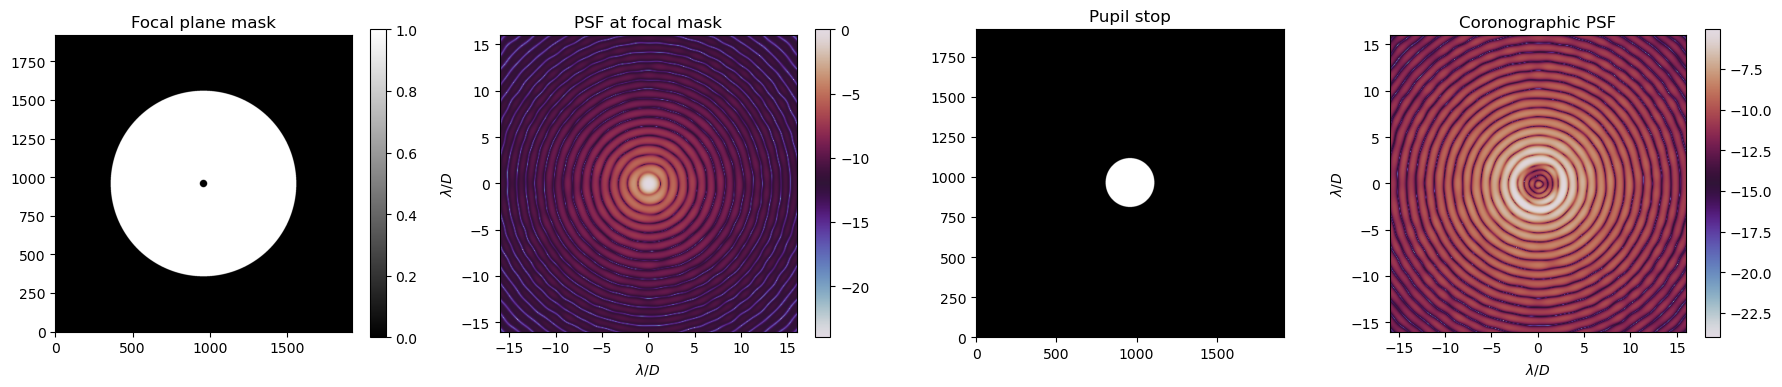

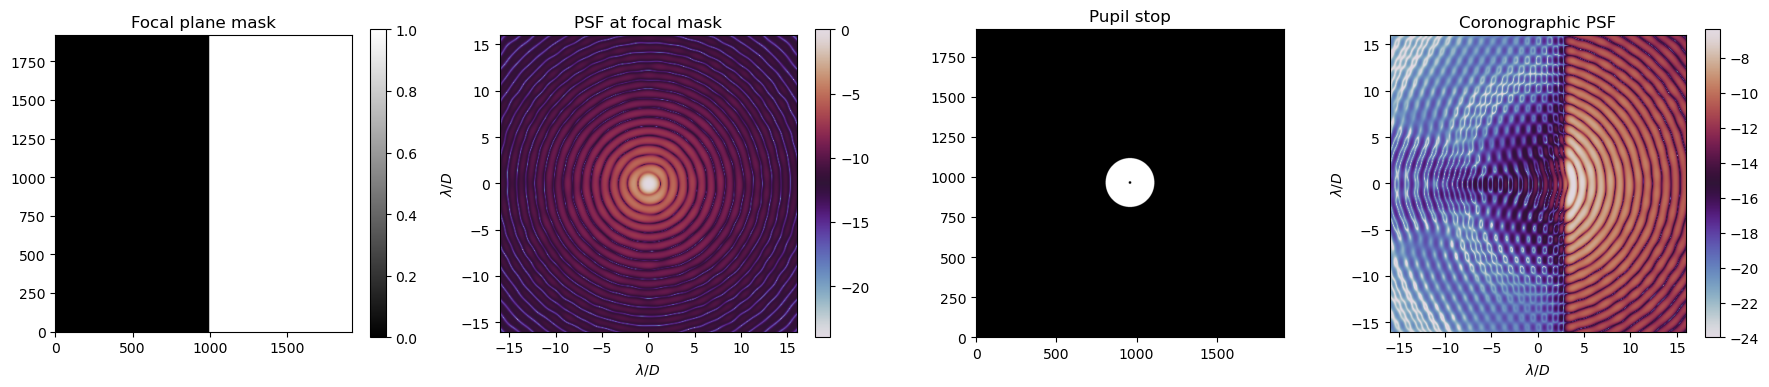

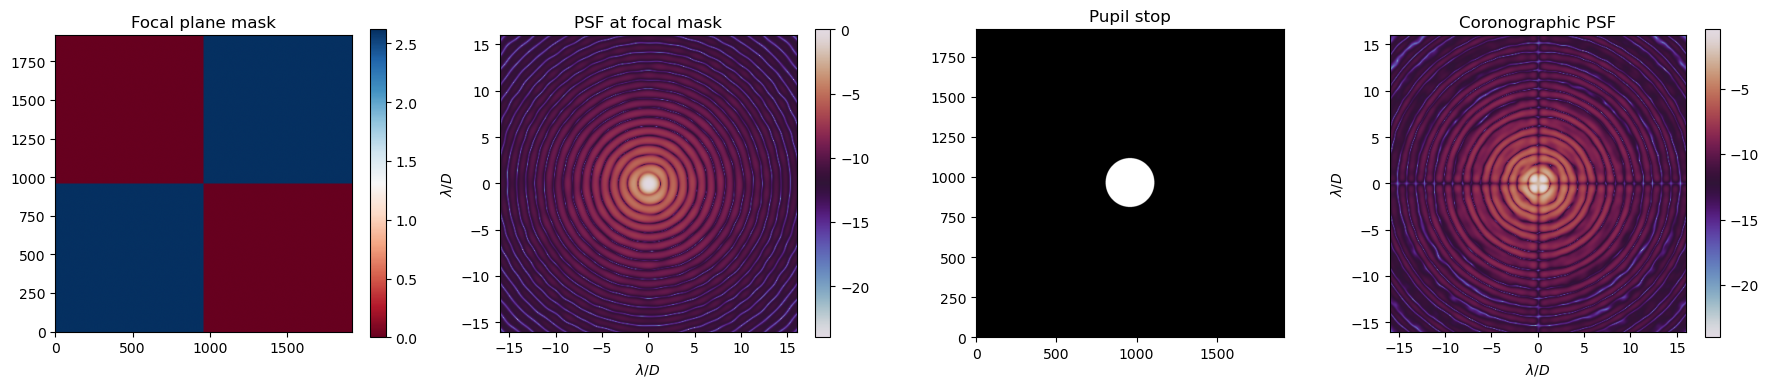

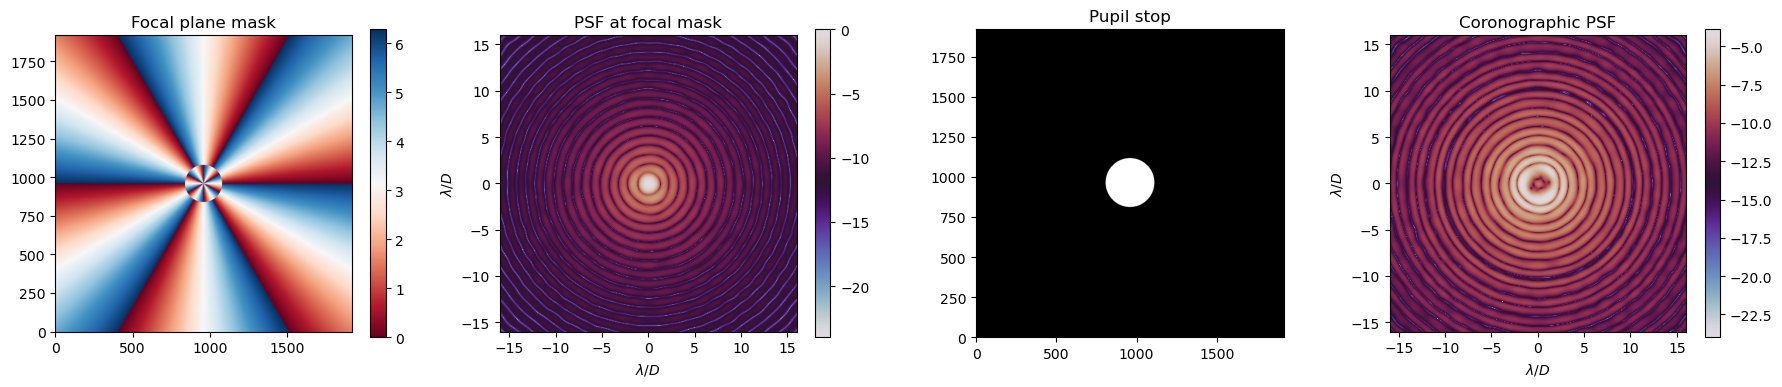

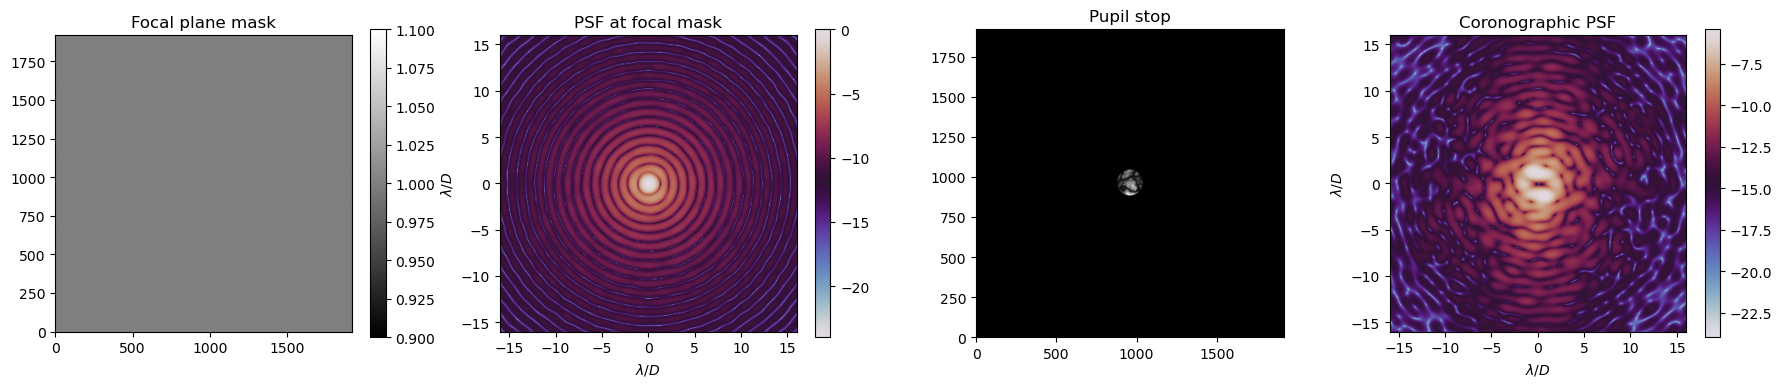

In [6]:
lyot.show_coronograph_prop(maxLogPsf)
kedge.show_coronograph_prop(maxLogPsf)
fquad.show_coronograph_prop(maxLogPsf)
vortex.show_coronograph_prop(maxLogPsf)
perfCoro.show_coronograph_prop(maxLogPsf)